# Task 1 – Dataset Creation and Preprocessing for xG Prediction

This notebook focuses on the **creation** and **progressive preprocessing** of datasets for the expected goals (xG) prediction task. Each dataset version (DS0 → DS4) represents a specific step in the pipeline:

- **DS0**: Baseline with core shot features and missing value handling

- **DS1**: Adds engineered geometric and contextual features

- **DS2**: Extends DS1 with freeze-frame derived features

- **DS3**: Adapted for **Logistic Regression** (one-hot encoding + scaling)

- **DS4**: Adapted for **tree ensembles and neural networks** (label encoding + embeddings)

Modeling strategy:  

- **Logistic Regression** serves as a **baseline** on DS3, providing a simple linear reference

- **Tree ensembles (Random Forest, XGBoost)** and **Neural Networks** are trained on DS4, which preserves categorical structure via embeddings and avoids sparse encodings

This design ensures a reproducible workflow, where the baseline is directly comparable to more advanced models, enabling **fair performance evaluation** across different families (linear, ensemble, neural)

## DS0: Basic Shots Information

DS0 represents the **baseline raw dataset**. It establishes the **minimal information set** available before the outcome.
The model inputs are:  

- **`location`** → decomposed into `location_x` and `location_y`, indicating the on-pitch coordinates of the attempt.  

- **`shot_end_location`** → decomposed into `shot_end_x` and `shot_end_y`, capturing where the attempt ended (goal, off target, blocked).  

- **`shot_type`** → categorical, distinguishing penalties, free kicks, open play shots, etc.  

- **`shot_technique`** → categorical, describing execution (e.g., volley, half-volley, normal).  

- **`shot_body_part`** → categorical, specifying right foot, left foot, or head.  

- **`play_pattern`** → categorical, describing the play context (counterattack, set piece, fast break).  

- **`under_pressure`** → binary, indicating defensive pressure at the attempt.  

- **`shot_first_time`** → binary, identifying shots taken without control. 

- **`shot_one_on_one`** → binary, flagging one-on-one situations with the goalkeeper.  

- **`shot_statsbomb_xg`** → continuous, the **target variable**, i.e., StatsBomb’s expected goals estimate.  

Certain variables are excluded to avoid leakage or redundancy:  

- **`shot_outcome`** would reveal the realized result, invalidating the ex-ante probability of xG.  

- **`shot_saved_to_post`** reflects post-shot information, thus unusable as a predictor.  

Finally, temporal variables (**`minute`, `second`, `period`**) are kept to verify if they directly affect the intrinsic probability of conversion.

> **NOTE**  
> The following identifier columns are kept only as **service keys**   to allow merging/enrichment in further datasets.  
> They **MUST NOT** be used as predictive features in the model:
>
> - **`id`** : unique identifier of the event (primary key in StatsBomb events)  
> - **`match_id`** : identifier of the match (needed to retrieve competition/season/gender)  
> - **`player_id`** : identifier of the player performing the event  

### Basic Info

In [199]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Load the basic shots dataset
shots_df = pd.read_csv("../task1_xg/data/shots_df.csv")

# Columns to keep for DS0
cols_keep = [
    "id", "match_id", "player_id",
    "minute", "second", "period", 
    "location", "shot_end_location",
    "shot_type", "shot_technique", "shot_body_part", "play_pattern",
    "under_pressure", "shot_first_time", "shot_one_on_one",
    "shot_statsbomb_xg"   # <-- target variable
]

# Build DS0
ds0 = shots_df[cols_keep].copy()

# Basic Info
print("="*50)
print("DATASET DS0 - BASIC INFO")
print("="*50)
print(f"Shape: {ds0.shape[0]} rows, {ds0.shape[1]} columns\n")

print("Column data types:")
print(ds0.dtypes)

# Missing values
print("\n" + "="*50)
print("MISSING VALUES")
print("="*50)
print(ds0.isna().sum())

# Numeric ranges
print("\n" + "="*50)
print("NUMERIC RANGES")
print("="*50)
num_cols = ["minute", "second", "period", "shot_statsbomb_xg"]
for col in num_cols:
    print(f"{col}: min={ds0[col].min()}  max={ds0[col].max()}")

print("\nshot_statsbomb_xg distribution:")
print(ds0["shot_statsbomb_xg"].describe())


# Categorical features
print("\n" + "="*50)
print("CATEGORICAL FEATURES")
print("="*50)
categorical = ["shot_type", "shot_technique", "shot_body_part", "play_pattern"]
for col in categorical:
    print(f"\n--- {col.upper()} ---")
    print("Unique values:", ds0[col].unique())
    print("\nValue counts:")
    print(ds0[col].value_counts(dropna=False))


# Binary flags
print("\n" + "="*50)
print("BINARY FLAGS")
print("="*50)
bin_flags = ["under_pressure", "shot_first_time", "shot_one_on_one"]
for col in bin_flags:
    print(f"\n--- {col.upper()} ---")
    print(ds0[col].value_counts(dropna=False))
    print("Unique values:", ds0[col].unique())

# Event Id Sample
print("\n" + "="*50)
print("EVENT ID SAMPLE")
print("="*50)
print(ds0["id"].sample(3).tolist())

# Verify id uniqueness and NaN
if ds0["id"].is_unique:
    print("\nAll Event IDs are unique\n")
if ds0["id"].isna().any():
    print("\nThere are NaN values in 'id' column\n")

# Location Fields
print("="*50)
print("LOCATION FIELDS (Preview)")
print("="*50)
print("Sample 'location':", ds0["location"].head(3).tolist())
print("Sample 'shot_end_location':", ds0["shot_end_location"].head(3).tolist())


DATASET DS0 - BASIC INFO
Shape: 88023 rows, 16 columns

Column data types:
id                    object
match_id               int64
player_id            float64
minute                 int64
second                 int64
period                 int64
location              object
shot_end_location     object
shot_type             object
shot_technique        object
shot_body_part        object
play_pattern          object
under_pressure        object
shot_first_time       object
shot_one_on_one       object
shot_statsbomb_xg    float64
dtype: object

MISSING VALUES
id                       0
match_id                 0
player_id                0
minute                   0
second                   0
period                   0
location                 0
shot_end_location        0
shot_type                0
shot_technique           0
shot_body_part           0
play_pattern             0
under_pressure       67132
shot_first_time      61373
shot_one_on_one      83362
shot_statsbomb_xg        0

###  Data Situation

The initial inspection of the **DS0 shot dataset** reveals the following:

- Categorical fields (`shot_type`, `shot_technique`, `shot_body_part`, `play_pattern`) are clean and have no missing values

- Binary flags (`under_pressure`, `shot_first_time`, `shot_one_on_one`) contain a high proportion of `NaN`, indicating that missing likely means “False”

- `minute`, `second`, and `period` ranges are valid (e.g., `period` up to 5 accounts for extra-time or penalty shootouts).

- `shot_statsbomb_xg` (our regression target) spans from ~0.0002 to ~0.995, with a realistic distribution (median ~0.055).

- Coordinate fields (`location`, `shot_end_location`) are stored as strings representing lists, needing parsing into numeric `x`, `y` components.

### Cleaning Pipeline for DS0

To prepare **DS0** for modeling, the following transformations are applied:

1. **Rename identifier column**
   - Column: `id`
   - Rename the `id` column to `event_id` to be more clear

2. **Fill missing binary flags with `False`**  
   - Columns: `under_pressure`, `shot_first_time`, `shot_one_on_one`  
   - Cast to boolean, since in this case Nan indicates a negative condition

3. **Parse coordinate fields**  
   - Convert `location` into numeric columns `loc_x`, `loc_y`
   - Convert `shot_end_location` into `end_shot_x`, `end_shot_y`, `end_shot_z`
   - Drop the original string-based columns afterward

4. **Validate numeric ranges**  
   - Ensure features such as pitch coordinates, seconds, and period values fall within expected limits

5. **Verify missing values**  
   - Confirm dataset completeness before proceeding

In [200]:
# 1) Rename "id" column into "event_id"
ds0 = ds0.rename(columns={"id": "event_id"})

# 2) Fill missing binary flags with False
bin_flags = ["under_pressure", "shot_first_time", "shot_one_on_one"]
for col in bin_flags:
    ds0[col] = ds0[col].fillna(False).astype(bool)              # Binary flags: NaN -> False

# 3) Parse coordinate fields (location and shot_end_location)
def parse_coords_basic(s):
    """Parse '[x, y]' or '[x, y, z]' string into list of floats"""
    vals = s.strip("[]").split(",")                 # remove brackets, split by comma
    vals = [float(v) for v in vals]                 # convert to floats
    return vals

# location -> loc_x, loc_y
ds0[["loc_x", "loc_y"]] = ds0["location"].apply(lambda x: pd.Series(parse_coords_basic(x)))

# shot_end_location -> end_shot_x, end_shot_y, end_shot_z
ds0[["end_shot_x", "end_shot_y", "end_shot_z"]] = ds0["shot_end_location"].apply(lambda x: pd.Series(parse_coords_basic(x)))

# Drop original string columns
ds0 = ds0.drop(columns=["location", "shot_end_location"])

# 4) Validate numeric ranges
def check_range(col, min_val, max_val):
    """Check if values in a column are within a specified range"""
    bad = ds0[(ds0[col] < min_val) | (ds0[col] > max_val)]
    if not bad.empty:
        print(f"{col} out of range values found:\n", bad[[col]].head())
    else:
        print(f"{col} within expected range [{min_val}, {max_val}]")

# Example checks
check_range("loc_x", 0, 120)
check_range("loc_y", 0, 80)
check_range("end_shot_x", 0, 120)
check_range("end_shot_y", 0, 80)
check_range("second", 0, 59)
check_range("period", 1, 5)

print("\nDS0 processed - shape:", ds0.shape)


loc_x out of range values found:
        loc_x
4682   120.2
5351   120.4
14663  120.1
61833  120.2
81525  120.1
loc_y within expected range [0, 80]
end_shot_x within expected range [0, 120]
end_shot_y within expected range [0, 80]
second within expected range [0, 59]
period within expected range [1, 5]

DS0 processed - shape: (88023, 19)


> **NOTE**: During the final check, a few `loc_x` values were found slightly above the official pitch limit.
It has been decided **not to clip these values**, since the deviation is very small (<1 meter) and they occur only 5 times in the all dataset of 88023 events. Leaving them as is preserves the fidelity of the raw data while remaining compatible with the modeling stage.


In [201]:
# 5) Verify Missing values in DS0
print("DTYPE SUMMARY")
print(ds0.dtypes)

print("\nMISSING VALUES")
print(ds0.isna().sum())

ds0.head(3)

DTYPE SUMMARY
event_id              object
match_id               int64
player_id            float64
minute                 int64
second                 int64
period                 int64
shot_type             object
shot_technique        object
shot_body_part        object
play_pattern          object
under_pressure          bool
shot_first_time         bool
shot_one_on_one         bool
shot_statsbomb_xg    float64
loc_x                float64
loc_y                float64
end_shot_x           float64
end_shot_y           float64
end_shot_z           float64
dtype: object

MISSING VALUES
event_id                 0
match_id                 0
player_id                0
minute                   0
second                   0
period                   0
shot_type                0
shot_technique           0
shot_body_part           0
play_pattern             0
under_pressure           0
shot_first_time          0
shot_one_on_one          0
shot_statsbomb_xg        0
loc_x                    0


event_id  match_id  player_id  minute  second  \
0  c577e730-b9f5-44f2-9257-9e7730c23d7b   3895302     8826.0       6      48   
1  bbc2c68d-c096-483d-abf4-32c0175a0f55   3895302    38004.0       7      40   
2  12b5206b-9ed0-4b1e-9ec3-f2028187e09f   3895302    51769.0      11       8   

   period  shot_type shot_technique shot_body_part    play_pattern  \
0       1  Open Play         Normal     Right Foot  From Free Kick   
1       1  Open Play         Normal      Left Foot    Regular Play   
2       1  Open Play         Normal      Left Foot  From Free Kick   

   under_pressure  shot_first_time  shot_one_on_one  shot_statsbomb_xg  loc_x  \
0           False             True            False           0.056644  100.4   
1            True             True            False           0.143381  114.6   
2           False             True            False           0.038188  106.2   

   loc_y  end_shot_x  end_shot_y  end_shot_z  
0   35.1       101.6        35.2         NaN  
1   33.5       118.1        35.7         0.2  
2   55.8       113.4        46.8         NaN

### Handling `end_shot_z` (shot end height)

The variable **`end_shot_z`** contains several **NaN values**.  
This is not an error: the height is only recorded when the shot reaches the goal area. 
For blocked or wayward attempts it is missing, as shown below in the code. 

A binary flag **`end_shot_z_available`** (1 = recorded, 0 = missing) is created and missing values are imputed with **-1**, to be interpreted only together with the flag.

In [202]:
# NOTE: Use the dataset shot_df to verify the shot_outcome link with end_shot_z

# Apply parsing
shots_df[["end_shot_x", "end_shot_y", "end_shot_z"]] = shots_df["shot_end_location"].apply(lambda x: pd.Series(parse_coords_basic(x)))

# Check NaN in end_shot_z against shot_outcome
check = shots_df[['shot_outcome', 'end_shot_z']].copy()
check['z_missing'] = check['end_shot_z'].isna()

print(check.groupby(['shot_outcome', 'z_missing']).size())


shot_outcome      z_missing
Blocked           True         21677
Goal              False         9790
Off T             False        28466
Post              False         1842
Saved             False        20788
Saved Off Target  False          349
Saved to Post     False          288
Wayward           True          4823
dtype: int64


In [203]:
# Now work with DS0 to create the necessary features and manage missing values

# Create availability flag
ds0['end_shot_z_available'] = ds0['end_shot_z'].notna().astype(int)

# Impute NaN with 0
ds0['end_shot_z'] = ds0['end_shot_z'].fillna(-1)


### Final Check, Target Definition and Save

At this stage, we define the target variable for our models.  
The **expected goals (xG)** value, provided by StatsBomb as `statsbomb_shot_xg`, is renamed to **`target_xg`** for clarity and consistency.  

The final preprocessed dataset is then saved as `DS0.csv`.


In [204]:
# Final dataset check before saving
report = []

for col in ds0.columns:
    dtype = ds0[col].dtype
    n_missing = ds0[col].isna().sum()

    if pd.api.types.is_numeric_dtype(ds0[col]):
        col_min = ds0[col].min()
        col_max = ds0[col].max()
        unique_vals = "-"
    else:
        col_min, col_max = "-", "-"
        unique_vals = ds0[col].unique()

    report.append([col, dtype, n_missing, col_min, col_max, unique_vals])

report_df = pd.DataFrame(report, columns=["Column", "Dtype", "Missing", "Min", "Max", "Unique Values"])
display(report_df)

Column    Dtype  Missing      Min       Max  \
0               event_id   object        0        -         -   
1               match_id    int64        0     7298   4020846   
2              player_id  float64        0   2935.0  482216.0   
3                 minute    int64        0        0       139   
4                 second    int64        0        0        59   
5                 period    int64        0        1         5   
6              shot_type   object        0        -         -   
7         shot_technique   object        0        -         -   
8         shot_body_part   object        0        -         -   
9           play_pattern   object        0        -         -   
10        under_pressure     bool        0    False      True   
11       shot_first_time     bool        0    False      True   
12       shot_one_on_one     bool        0    False      True   
13     shot_statsbomb_xg  float64        0  0.00018  0.995122   
14                 loc_x  float64        0     30.2     120.5   
15                 loc_y  float64        0      0.3      80.0   
16            end_shot_x  float64        0     66.5     120.0   
17            end_shot_y  float64        0      0.1      80.0   
18            end_shot_z  float64        0     -1.0       7.8   
19  end_shot_z_available    int64        0        0         1   

                                        Unique Values  
0   [c577e730-b9f5-44f2-9257-9e7730c23d7b, bbc2c68...  
1                                                   -  
2                                                   -  
3                                                   -  
4                                                   -  
5                                                   -  
6   [Open Play, Penalty, Free Kick, Corner, Kick Off]  
7   [Normal, Volley, Half Volley, Lob, Backheel, O...  
8                [Right Foot, Left Foot, Head, Other]  
9   [From Free Kick, Regular Play, From Corner, Ot...  
10                                                  -  
11                                                  -  
12                                                  -  
13                                                  -  
14                                                  -  
15                                                  -  
16                                                  -  
17                                                  -  
18                                                  -  
19                                                  -

In [205]:
# Rename target column
ds0 = ds0.rename(columns={"shot_statsbomb_xg": "target_xg"})

# Save final dataset
output_path = "../task1_xg/data/DS0.csv"
ds0.to_csv(output_path, index=False)

print(f"Dataset saved successfully as {output_path}")
print("Final shape:", ds0.shape)


Dataset saved successfully as ../task1_xg/data/DS0.csv
Final shape: (88023, 20)


## DS1: Feature Engineering and Contextual Enrichment

Starting from the aw shot-level dataset **DS0**, DS1 applies a first round of **feature engineering** to reduce redundancy, simplify categorical variables, and add geometric/contextual information.  

The main modifications are:  

1. **Set-Piece Indicator (`shot_from_set_piece`)**  
   Derived from the categorical column `shot_type`:  
   - `1` → Penalty, Free Kick, Corner, Kick Off  
   - `0` → Open Play  

   This preserves the distinction between open play and set pieces without relying on multiple categories.  

2. **Shooting Technique Aggregation (`shot_technique`)**  
   The raw column `shot_technique` is mapped into **three broader groups**:  
   - `Normal` → standard controlled shots  
   - `Aerial` → volleys, headers, overheads  
   - `Special` → backheels, lobs, tricks  

   This reduces sparsity and improves robustness while keeping tactical interpretability.  

3. **Spatial Features (`distance_to_goal`, `angle_to_goal`)**  
   Computed from `(loc_x, loc_y)` relative to the goal center (x=120, y=40):  
   - `distance_to_goal`: Euclidean distance to goal center  
   - `angle_to_goal`: opening angle to the two goalposts

   These features encode shot geometry directly in continuous variables.  

4. **Period Simplification (`period`)**  
   The numeric column `period` (1–5) is collapsed into three categories:  
   - `Regular Time` (1–2)  
   - `Extra Time` (3–4)  
   - `Penalty` (5)  

   This keeps the temporal context compact and interpretable.  

5. **Play Context (`play_context`)**  
   The original `play_pattern` is grouped into three macro-categories:  
   - `Regular Play`  
   - `Counter Attack`  
   - `Set Piece`  

6. **Competition Gender (`gender`)**  
   A new categorical variable distinguishing male vs female competitions, to test potential context-specific biases in xG.  

7. **Shooter Role (`ShooterRole`)**  
   Based on `player_id` mapped to lineup positions, the shooter’s tactical role is added in three macro-categories:  
   
   - Goalkeeper (`GK`)
   - Goalkeeper or Defender  (`DEF`)  
   - Midfielder (`MID`)  
   - Forward (`FWD`)  

   This introduces contextual knowledge without leaking player identity.  


### 1) Introduction of `shot_from_set_piece`

The column `shot_type` contains the original categorical description of the shot (e.g., *Penalty*, *Free Kick*, *Corner*, *Kick Off*, *Open Play*). The new variable `shot_from_set_piece` is derived by mapping these categories into a binary indicator:  

- `1` if the shot originates from a set piece (Penalty, Free Kick, Corner, Kick Off)  
- `0` if the shot originates from open play  

In [206]:
import pandas as pd

# Load DS0
ds0 = pd.read_csv("../task1_xg/data/DS0.csv")

# Print unique values of shot_type
print(ds0["shot_type"].unique())

# Show frequencies
print(ds0["shot_type"].value_counts())

['Open Play' 'Penalty' 'Free Kick' 'Corner' 'Kick Off']
shot_type
Open Play    82402
Free Kick     4231
Penalty       1361
Corner          28
Kick Off         1
Name: count, dtype: int64


In [207]:
# Create a copy of the original DataFrame
ds1 = ds0.copy()

# Define set-piece shot types
set_pieces = ['Penalty', 'Free Kick', 'Corner', 'Kick Off']

# Create a new binary column: 1 if the shot comes from a set piece, 0 otherwise
ds1["shot_from_set_piece"] = ds1["shot_type"].isin(set_pieces).astype(int)

In [208]:
# Validation
print("DS0 Original Features")
print(f"Open play: {(ds0['shot_type'] == 'Open Play').sum()}")
print(f"Set pieces: {ds0['shot_type'].isin(set_pieces).sum()}")

count_ds1 = ds1["shot_from_set_piece"].value_counts()

print("\nDS1 Shot From Set Piece")
print(f"Open play (0): {count_ds1[0]}")
print(f"Set pieces (1): {count_ds1[1]}")

DS0 Original Features
Open play: 82402
Set pieces: 5621

DS1 Shot From Set Piece
Open play (0): 82402
Set pieces (1): 5621


### 2) Grouping of `shot_technique` into Normal, Aerial, and Special

The original `shot_technique` variable contains several categories with highly unbalanced frequencies, where most observations fall into the `Normal` class and only a few correspond to rare techniques. This imbalance introduces **sparsity** and limits the predictive usefulness of the feature. 

By grouping related techniques into broader categories (Normal, Aerial, Special), we reduce this imbalance and noise, leading to a modest but meaningful improvement in robustness. The new representation enhances **generalization** by preventing the model from overfitting to rare cases, while also improving **interpretability**, since the categories now capture intuitive tactical distinctions in how shots are executed.  


In [209]:
# Print unique values of shot_technique in DS0
print(ds0["shot_technique"].unique())

# Show frequencies
print(ds0["shot_technique"].value_counts())

['Normal' 'Volley' 'Half Volley' 'Lob' 'Backheel' 'Overhead Kick'
 'Diving Header']
shot_technique
Normal           68665
Half Volley      11712
Volley            5638
Lob                878
Overhead Kick      454
Backheel           346
Diving Header      330
Name: count, dtype: int64


In [210]:
# Create grouped shot_technique feature
def map_shot_technique(tech):
    if tech in ["Half Volley", "Volley", "Diving Header"]:
        return "Aerial"
    elif tech in ["Lob", "Overhead Kick", "Backheel"]:
        return "Special"
    elif pd.notna(tech):
        return "Normal"
    else:
        return "Unknown"  # in case of missing values

ds1["shot_technique"] = ds1["shot_technique"].apply(map_shot_technique)

# Quick check
print(ds1["shot_technique"].value_counts())

shot_technique
Normal     68665
Aerial     17680
Special     1678
Name: count, dtype: int64


In [211]:
# Validation checks
print("Check Normal")
print("DS0:", ds0["shot_technique"].isin(["Normal"]).sum())
print("DS1:", ds1["shot_technique"].isin(["Normal"]).sum(), "\n")

print("Check Aerial")
print("DS0:", ds0["shot_technique"].isin(["Half Volley", "Volley", "Diving Header"]).sum())
print("DS1:", ds1["shot_technique"].isin(["Aerial"]).sum(), "\n")

print("Check Special")
print("DS0:", ds0["shot_technique"].isin(["Backheel", "Lob", "Overhead Kick"]).sum())
print("DS1:", ds1["shot_technique"].isin(["Special"]).sum(), "\n")

# Global consistency check
print("Total")
print("DS0:", ds0["shot_technique"].notna().sum())
print("DS1:", ds1["shot_technique"].notna().sum())


Check Normal
DS0: 68665
DS1: 68665 

Check Aerial
DS0: 17680
DS1: 17680 

Check Special
DS0: 1678
DS1: 1678 

Total
DS0: 88023
DS1: 88023


### 3) Introduction of Shot Distance and Shot Angle

The dataset is enriched with two engineered features derived from `loc_x`, `loc_y`:

- **Shot Distance**: the Euclidean distance between the shot location and the center of the goal (x=120, y=40). This feature captures how far the shooter was from the target. 

- **Shot Angle**: the angle under which the shooter sees the two goalposts  (left post at x=120, y=36; right post at x=120, y=44). This represents the scoring angle. In general, wider angles correspond to higher scoring  probabilities.

In [212]:
import numpy as np

# Goal dimensions in StatsBomb coordinates (120x80)
GOAL_X = 120
GOAL_Y_TOP = 44
GOAL_Y_BOTTOM = 36
GOAL_CENTER_Y = 40


def compute_distance(x, y):
    """
    Compute the Euclidean distance between a location (x,y) and the center of the opponent's goal
    
    Formula:
        d = sqrt((GOAL_X - x)^2 + (GOAL_CENTER_Y - y)^2)
    
    Parameters:
        x (float): x start position of the shot
        y (float): y start position of the shot

    Returns:
        distance (float): Distance to the goal center, measured in meters
    """
    return np.sqrt((GOAL_X - x) ** 2 + (GOAL_CENTER_Y - y) ** 2)


def compute_angle(x, y):
    """
    Compute the visible shooting angle of the goal from a given location (x,y)
    
    From the player's location, two lines are computed: one to the top post and one to the bottom post
    The difference in their angles (w.r.t the x-axis) gives the apparent opening angle of the goal
    If the player is on or beyond the goal line (x >= GOAL_X), the angle is set to 0
    
    The atan2 is used because it provides the angle between the positive x-axis and 
    the lines, taking into account the signs of both coordinates to determine the correct quadrant

    Formula:
        angle = | atan2(GOAL_Y_TOP - y, GOAL_X - x) - atan2(GOAL_Y_BOTTOM - y, GOAL_X - x) |

    Parameters:
        x (float): x start position of the shot
        y (float): y start position of the shot

    Returns:
        angle (float): Visible angle of the goal in radians (range: [0, π])
    """

    if GOAL_X - x <= 0:  # shot beyond/at goal line
        return 0.0
    
    angle_top = np.arctan2((GOAL_Y_TOP - y),  GOAL_X - x)
    angle_bottom = np.arctan2((GOAL_Y_BOTTOM - y),  GOAL_X - x)
    return abs(angle_top - angle_bottom)


# Add new features to the dataset
ds1["distance_to_goal"] = ds1.apply(lambda row: compute_distance(row["loc_x"], row["loc_y"]), axis=1)
ds1["angle_to_goal"] = ds1.apply(lambda row: compute_angle(row["loc_x"], row["loc_y"]), axis=1)

# Show results
print("New features: distance to goal & angle to goal")
print(ds1[["loc_x", "loc_y", "distance_to_goal", "angle_to_goal"]].head(10))


New features: distance to goal & angle to goal
   loc_x  loc_y  distance_to_goal  angle_to_goal
0  100.4   35.1         20.203218       0.380357
1  114.6   33.5          8.450444       0.662204
2  106.2   55.8         20.978084       0.254675
3  113.9   47.4          9.590099       0.570985
4   89.2   42.5         30.901294       0.256650
5  110.2   32.6         12.280065       0.526782
6  105.4   45.1         15.465122       0.482167
7  108.0   40.0         12.000000       0.643501
8  101.5   47.5         19.962465       0.369187
9  116.3   46.0          7.049113       0.720865


In [213]:
# Min and Max values for distance and angle
print("Min and Max values for distance to goal:")
print(ds1["distance_to_goal"].min(), ds1["distance_to_goal"].max())

print("\nMin and Max values for angle to goal:")
print(ds1["angle_to_goal"].min(), ds1["angle_to_goal"].max())

Min and Max values for distance to goal:
0.3999999999999986 92.80086206496145

Min and Max values for angle to goal:
0.0 2.9427443102583553


### 4) Period Semplification

In [214]:
# Check unique values for period column

print("Unique values in period:")
print(ds1["period"].unique())

print(ds1["period"].value_counts().sort_index())

Unique values in period:
[1 2 5 3 4]
period
1    40040
2    47149
3      224
4      247
5      363
Name: count, dtype: int64


In [215]:
# Map period into 3 values
def map_period(p):
    if p in [1, 2]:
        return "Regular Time"
    elif p in [3, 4]:
        return "Extra Time"
    elif p == 5:
        return "Penalty"
    else:
        return "Unknown"

ds1["period"] = ds1["period"].map(map_period)

In [216]:
# Check
print(ds1["period"].value_counts())

print("\nSum of periods:", ds1["period"].count())

period
Regular Time    87189
Extra Time        471
Penalty           363
Name: count, dtype: int64

Sum of periods: 88023


### 5) Introduction of `play_context`

In [217]:
# Check unique values for play_pattern column
print("Unique values in play_pattern:")
print(ds1["play_pattern"].unique())

print(ds1["play_pattern"].value_counts())

Unique values in play_pattern:
['From Free Kick' 'Regular Play' 'From Corner' 'Other' 'From Keeper'
 'From Throw In' 'From Goal Kick' 'From Counter' 'From Kick Off']
play_pattern
Regular Play      29180
From Free Kick    18018
From Throw In     15502
From Corner       14084
From Counter       3979
From Goal Kick     3340
Other              1526
From Keeper        1388
From Kick Off      1006
Name: count, dtype: int64


In [218]:
# Explicit mapping of all play_pattern values
pattern_map = {
    "Regular Play": "Regular Play",
    "From Counter": "Counter Attack",
    "From Free Kick": "Set Piece",
    "From Corner": "Set Piece",
    "From Keeper": "Set Piece",
    "From Throw In": "Regular Play",
    "From Goal Kick": "Set Piece",
    "From Kick Off": "Set Piece",
    "Other": "Set Piece"  # fallback category
}

# Apply mapping
ds1["play_pattern"] = ds1["play_pattern"].map(pattern_map)


In [219]:
# Check
print(ds1["play_pattern"].value_counts())
print("\nSum of play patterns:", ds1["play_pattern"].count())

play_pattern
Regular Play      44682
Set Piece         39362
Counter Attack     3979
Name: count, dtype: int64

Sum of play patterns: 88023


### 6) Enrichment with competition gender

Including the `gender` category enables the model to capture systematic differences between men’s and women’s competitions that may influence expected goals (xG)

The workflow operates as follows:

1. DS0 already includes `match_id` for every shot event

2. For each competition-season pair, retrieve match data via `sb.matches()`. Each returned match record includes `match_id`, as well as text fields `competition` and `season`

3. The `competition` field in the `matches` output appears in a format like `"Spain - La Liga"`. To align it with the competition names in `sb.competitions()` (which uses `"competition_name"`), the code splits the string at the first dash (`-`) and uses the second part (e.g. `"La Liga"`). Then it's stripped and renamed to `"competition_name"`

4. After standardizing the competition and season names, merge with the `sb.competitions()` metadata (which includes `competition_gender`) using `[competition_name, season_name]` as keys

5. The result of this join yields a mapping `match_id → gender`, which is then merged back into DS0 to produce **DS1**, containing the additional column `gender`

In [220]:
import pandas as pd
from statsbombpy import sb

# Create a copy of ds1 to work with
ds1_copy = ds1.copy()

# Retrieve all competitions data, keeping only the relevant columns
competitions = sb.competitions()
competitions = competitions[[
    "competition_id", 
    "season_id", 
    "competition_name", 
    "season_name", 
    "competition_gender"
]]

# Extract the set of unique match_ids from DS1
unique_match_ids = set(ds1_copy["match_id"].unique())

# Container for match metadata
match_data = []

# Iterate over each competition-season pair
for _, row in competitions.iterrows():
    comp_id = row["competition_id"]
    season_id = row["season_id"]

    try:
        # Retrieve all matches metadata for this competition-season
        matches = sb.matches(competition_id=comp_id, season_id=season_id)

        # Normalize competition name (remove "country -")
        matches["competition"] = matches["competition"].str.split("-").str[1].str.strip()

        # Rename columns to align with competitions DataFrame
        matches = matches.rename(columns={
            "competition": "competition_name",
            "season": "season_name",
        })

        # Keep only relevant matches
        matches = matches[matches["match_id"].isin(unique_match_ids)]

        if not matches.empty:
            # Merge with competitions metadata to attach the gender
            matches = matches.merge(
                competitions,
                on=["competition_name", "season_name"],
                how="left"
            )
            match_data.append(matches)
    except Exception as e:
        print(f"Error fetching comp={comp_id}, season={season_id}: {e}")

# Concatenate all collected matches into a single DataFrame
df_matches = pd.concat(match_data, ignore_index=True)

# Keep only match_id and gender, removing duplicates
df_matches = df_matches[["match_id", "competition_gender"]].drop_duplicates()

# Rename column for clarity
df_matches = df_matches.rename(columns={"competition_gender": "gender"})

# Update the original ds1
ds1 = ds1_copy.merge(df_matches, on="match_id", how="left")

print("DS1 shape:", ds1.shape)
print(ds1[["match_id", "gender"]].head())


DS1 shape: (88023, 24)
   match_id gender
0   3895302   male
1   3895302   male
2   3895302   male
3   3895302   male
4   3895302   male


In [221]:
# Verify if there are NaN values in gender
missing_gender = ds1["gender"].isna().sum()
print(f"Number of NaN values in gender: {missing_gender}")

# Show rows with missing gender (if any)
if missing_gender > 0:
    display(ds1[ds1["gender"].isna()])


Number of NaN values in gender: 0


### 7) Integrating Player Role Information into Shot Data

#### Building the Roles Dataset

All possible **player roles** available in the StatsBomb open data are first collected by iterating through competitions, matches, and Starting XI events into the file `unique_roles.csv`.  

In [222]:
from statsbombpy import sb
import pandas as pd
from tqdm import tqdm
import warnings
import os

warnings.filterwarnings("ignore")

# Path where the roles file will be saved
roles_file = "../task1_xg/data/unique_roles.csv"

# Check if the file already exists
if os.path.exists(roles_file):
    print(f"File '{roles_file}' already exists. Skipping extraction.")
    roles_df = pd.read_csv(roles_file)
else:
    # Container for unique player roles
    all_roles = set()
    skipped_matches = 0

    # Load all available competitions from StatsBomb and sort them by season
    comps = sb.competitions().sort_values(by="season_name")

    # Iterate over competitions with a progress bar
    for _, comp in tqdm(comps.iterrows(), total=len(comps), desc="Competitions"):
        comp_id = comp["competition_id"]
        season_id = comp["season_id"]

        # Load all matches for the given competition and season
        matches = sb.matches(competition_id=comp_id, season_id=season_id)

        # Iterate over all matches (no progress bar to keep it lighter)
        for match_id in matches["match_id"].unique():

            # Load event data for the match
            events = sb.events(match_id=match_id)

            # Filter Starting XI events
            starting_xi = events[events["type"] == "Starting XI"]

            # For each Starting XI (one per team), extract player roles
            for i in range(len(starting_xi)):
                lineup = starting_xi.iloc[i]["tactics"].get("lineup", [])
                for player in lineup:
                    role = player.get("position", {}).get("name")
                    if role:
                        all_roles.add(role)


    # Save all unique roles into a DataFrame
    roles_df = pd.DataFrame(sorted(all_roles), columns=["role"])

    print(f"\nFile '{roles_file}' saved with", len(roles_df), "unique roles.")


File '../task1_xg/data/unique_roles.csv' already exists. Skipping extraction.


Subsequently, these detailed roles are mapped into broader macro-categories (Goalkeeper, Defender, Midfielder, Forward).  

In [223]:
# Mapping detailed roles into macro categories
role_to_macro = {
    "Goalkeeper": "GK",
    "Left Back": "DEF", "Left Center Back": "DEF", "Center Back": "DEF",
    "Right Center Back": "DEF", "Right Back": "DEF",
    "Left Wing Back": "DEF", "Right Wing Back": "DEF",

    "Left Defensive Midfield": "MID", "Left Center Midfield": "MID",
    "Center Defensive Midfield": "MID", "Center Midfield": "MID",
    "Center Attacking Midfield": "MID", "Right Center Midfield": "MID",
    "Right Defensive Midfield": "MID", "Left Midfield": "MID",
    "Right Midfield": "MID", "Left Attacking Midfield": "MID",
    "Right Attacking Midfield": "MID",

    "Left Wing": "FWD", "Right Wing": "FWD",
    "Left Center Forward": "FWD", "Center Forward": "FWD",
    "Right Center Forward": "FWD", "Secondary Striker": "FWD"
}

# Add macro_role column
roles_df["macro_role"] = roles_df["role"].map(role_to_macro)

# Save updated roles file
roles_df.to_csv(roles_file, index=False)
print(f"Updated file saved to '{roles_file}' with macro roles included.")

Updated file saved to '../task1_xg/data/unique_roles.csv' with macro roles included.


#### Macro Roles Assignment to DS1

Each player can be assigned multiple roles during the course of a match. Since a player may switch positions at different times, it is not sufficient to assign a single static role to all their actions. Instead, the role at the **exact moment of the shot** must be identified.  

To achieve this, the temporal intervals associated with each role are compared with the minute and second of the shot. The player’s active role is then extracted by verifying which role assignment was valid at that specific minute and second of the match. This ensures that the dataset reflects the tactical context of the shot more accurately, linking each attempt not only to the player but also to the position they were occupying at that point in time.  

> **Note on edge cases**:  
> If no role matches the shot minute (e.g., due to missing or incomplete time intervals), the player’s **initial role** is assigned  
> If the lineup contains no role information for the player at all, the process stops to avoid introducing misleading data

In [224]:
from statsbombpy import sb

# Test: pick a random match (here we take the first from World Cup 2018)
matches = sb.matches(competition_id=43, season_id=3)  
match_id = matches.iloc[0]["match_id"]

# Load lineups for the match
lineups = sb.lineups(match_id)

# Select the first team for example
team = list(lineups.keys())[0]
players_df = lineups[team]

# Pick the first player 
player_row = players_df.iloc[0]

print("TEST: Player info from lineups")
print("Player ID:", player_row["player_id"])
print("Player Name:", player_row["player_name"])
print("Positions recorded:")

# The 'positions' column is a list of dicts, one per role/time interval
for pos in player_row["positions"]:
    print(f" - {pos['position']} (from {pos['from']} to {pos['to']})")


TEST: Player info from lineups
Player ID: 3094
Player Name: Bamidele Alli
Positions recorded:
 - Left Attacking Midfield (from 00:00 to 48:20)
 - Left Attacking Midfield (from 49:38 to 80:01)


In [225]:
import pandas as pd
from statsbombpy import sb
from tqdm import tqdm

def time_to_minutes(t):
    """Convert lineup time string (e.g., '45:00') into minutes (float)."""

    if t is None or t == "":
        return float("inf")   # if "to" is None or empty, role lasts until the end of the match
    
    if isinstance(t, (int, float)):
        return float(t)
    
    if isinstance(t, str) and ":" in t:
        mm, ss = t.split(":")
        return int(mm) + int(ss) / 60.0
    
    return float(t)


# Cache to avoid downloading the same lineup multiple times
lineups_cache = {}
roles_data = []

# Iterate over all matches in the dataset
for match_id in tqdm(ds1["match_id"].unique(), desc="Downloading lineups"):
    if match_id in lineups_cache:
        lineups = lineups_cache[match_id]
    else:
        try:
            lineups = sb.lineups(match_id)
            lineups_cache[match_id] = lineups
        except Exception:
            # Some matches may not have a lineup available
            continue

    # Build a dictionary {player_id: list of positions (with from/to times)}
    match_roles = {}
    for team, players in lineups.items():
        for _, row in players.iterrows():
            match_roles[row["player_id"]] = row["positions"]

    # For each shot in this match, find the role of the shooter
    match_shots = ds1[ds1["match_id"] == match_id]
    for _, shot in match_shots.iterrows():
        pid = shot["player_id"]
        minute = shot["minute"]
        role_at_shot = None

        # Case 1: player has positions available in the minute of the shot
        if pid in match_roles and isinstance(match_roles[pid], list) and len(match_roles[pid]) > 0:
            # First, try to find the role valid at the shot's minute
            for pos in match_roles[pid]:
                start = time_to_minutes(pos["from"])
                end = time_to_minutes(pos["to"])
                if start <= minute <= end:
                    role_at_shot = pos["position"]
                    break

            # Case 2: if no role matches the shot minute, use the initial role
            if role_at_shot is None:
                role_at_shot = match_roles[pid][0]["position"]

        # Case 3: player has no role information in the lineup
        else:
            raise SystemExit("Stopped: player without any role information in lineup.")

        # Store (event_id, role)
        roles_data.append({
            "event_id": shot["event_id"],
            "role": role_at_shot
        })

# Merge the role information back into ds1
roles_df = pd.DataFrame(roles_data)
ds1 = ds1.merge(roles_df, on="event_id", how="left")

# Keep only original ds1 columns + new role column
cols_to_keep = list(ds1.columns)
ds1 = ds1[cols_to_keep].copy()

# Load mapping role → macro_role
unique_roles = pd.read_csv("../task1_xg/data/unique_roles.csv")

# Add macro_role to ds1
ds1 = ds1.merge(unique_roles[["role", "macro_role"]], on="role", how="left")

# Drop detailed role column, keep only macro_role
ds1 = ds1.drop(columns=["role"])


In [226]:
# Rename macro_role -> role
ds1 = ds1.rename(columns={"macro_role": "role"})

# Verify role distribution
print("Role distribution:")
print(ds1["role"].value_counts(dropna=False))

# Check if all shots have a role assigned
missing_roles = ds1[ds1["role"].isna()]
if missing_roles.empty:
    print("\nAll shots have a role assigned to the shooter.")
else:
    print(f"\nFound {len(missing_roles)} shots without an assigned role.")
    print("Example rows:")
    print(missing_roles.head())

Role distribution:
role
FWD    41449
MID    32329
DEF    14228
GK        17
Name: count, dtype: int64

All shots have a role assigned to the shooter.


### Final Check and Save

The final dataset is then saved as `DS1.csv`.

In [227]:
# Final dataset check before saving
report = []

for col in ds1.columns:
    dtype = ds1[col].dtype
    n_missing = ds1[col].isna().sum()

    if pd.api.types.is_numeric_dtype(ds1[col]):
        col_min = ds1[col].min()
        col_max = ds1[col].max()
        unique_vals = "-"
    else:
        col_min, col_max = "-", "-"
        unique_vals = ds1[col].unique()

    report.append([col, dtype, n_missing, col_min, col_max, unique_vals])

report_df = pd.DataFrame(report, columns=["Column", "Dtype", "Missing", "Min", "Max", "Unique Values"])
display(report_df)

Column    Dtype  Missing      Min        Max  \
0               event_id   object        0        -          -   
1               match_id    int64        0     7298    4020846   
2              player_id  float64        0   2935.0   482216.0   
3                 minute    int64        0        0        139   
4                 second    int64        0        0         59   
5                 period   object        0        -          -   
6              shot_type   object        0        -          -   
7         shot_technique   object        0        -          -   
8         shot_body_part   object        0        -          -   
9           play_pattern   object        0        -          -   
10        under_pressure     bool        0    False       True   
11       shot_first_time     bool        0    False       True   
12       shot_one_on_one     bool        0    False       True   
13             target_xg  float64        0  0.00018   0.995122   
14                 loc_x  float64        0     30.2      120.5   
15                 loc_y  float64        0      0.3       80.0   
16            end_shot_x  float64        0     66.5      120.0   
17            end_shot_y  float64        0      0.1       80.0   
18            end_shot_z  float64        0     -1.0        7.8   
19  end_shot_z_available    int64        0        0          1   
20   shot_from_set_piece    int64        0        0          1   
21      distance_to_goal  float64        0      0.4  92.800862   
22         angle_to_goal  float64        0      0.0   2.942744   
23                gender   object        0        -          -   
24                  role   object        0        -          -   

                                        Unique Values  
0   [c577e730-b9f5-44f2-9257-9e7730c23d7b, bbc2c68...  
1                                                   -  
2                                                   -  
3                                                   -  
4                                                   -  
5                 [Regular Time, Penalty, Extra Time]  
6   [Open Play, Penalty, Free Kick, Corner, Kick Off]  
7                           [Normal, Aerial, Special]  
8                [Right Foot, Left Foot, Head, Other]  
9           [Set Piece, Regular Play, Counter Attack]  
10                                                  -  
11                                                  -  
12                                                  -  
13                                                  -  
14                                                  -  
15                                                  -  
16                                                  -  
17                                                  -  
18                                                  -  
19                                                  -  
20                                                  -  
21                                                  -  
22                                                  -  
23                                     [male, female]  
24                                [MID, DEF, FWD, GK]

In [228]:
# Save DS1 to disk
ds1.to_csv("../task1_xg/data/DS1.csv", index=False)

## DS2: Incorporating Freeze-Frame Features

Almost every shot in the StatsBomb dataset is accompanied by a *freeze frame*, a snapshot capturing the positions of **players on the pitch** at the exact moment the shot is taken.  

This information enables valuable feature engineering, for example:  

- **Number of players between shooter and goal**  
  Discrete measure reflecting defensive density directly blocking the shooting line.  

- **Distance to the closest defender**  
  Continuous variable quantifying the level of immediate defensive pressure on the shooter.  

- **Goalkeeper positioning**  
  Derived from the goalkeeper’s x/y coordinates or their distance to the shooter, both strongly influencing scoring probability.  

- **Free projection of the goal**  
  Advanced feature estimating the proportion of the goal area left uncovered, by projecting the goalkeeper’s position relative to the posts into the shooter’s field of view.  

Together, these features encode the **spatial and tactical context** of a shot, moving beyond simple descriptors like location or body part.

### Analysis of Freeze Frames

In [229]:
import pandas as pd

# Load shots data
shots = pd.read_csv("../task1_xg/data/shots_df.csv")

In [230]:
import ast
import json

# Extract the freeze frame string for a given shot (first shot)
ff_str = shots.loc[0, "shot_freeze_frame"]

# Convert the string into a list of dicts
ff_obj = ast.literal_eval(ff_str)

# Pretty print the freeze frame as JSON
print(json.dumps(ff_obj, indent=2))


[
  {
    "location": [
      101.9,
      35.1
    ],
    "player": {
      "id": 3500,
      "name": "Granit Xhaka"
    },
    "position": {
      "id": 9,
      "name": "Right Defensive Midfield"
    },
    "teammate": false
  },
  {
    "location": [
      107.2,
      38.1
    ],
    "player": {
      "id": 30606,
      "name": "Edmond Fay\u00e7al Tapsoba"
    },
    "position": {
      "id": 5,
      "name": "Left Center Back"
    },
    "teammate": false
  },
  {
    "location": [
      112.9,
      42.4
    ],
    "player": {
      "id": 38004,
      "name": "Piero Mart\u00edn Hincapi\u00e9 Reyna"
    },
    "position": {
      "id": 8,
      "name": "Left Wing Back"
    },
    "teammate": false
  },
  {
    "location": [
      110.4,
      29.4
    ],
    "player": {
      "id": 8221,
      "name": "Jonathan Tah"
    },
    "position": {
      "id": 4,
      "name": "Center Back"
    },
    "teammate": false
  },
  {
    "location": [
      92.1,
      29.0
    ],
    "player"

In [231]:
# Check for NaN in freeze frame column
nan_count = shots["shot_freeze_frame"].isna().sum()
total = len(shots)

print(f"Total shots: {total}")
print(f"Shots with NaN freeze frame: {nan_count}")
print(f"Percentage of shots with NaN freeze frame: {(nan_count/total)*100:.2f}%")

Total shots: 88023
Shots with NaN freeze frame: 1190
Percentage of shots with NaN freeze frame: 1.35%


### Handling missing freeze frames

In the StatsBomb dataset, **1,190 shots out of 88,023** do not contain freeze frame information.  
It has been decided to **remove these shots**.  This choice does not affect the robustness of the analysis because the missing freeze frames represent only **a very small fraction (1.35%)** of the total dataset. The remaining **98.65% of shots** provide complete and reliable data, ensuring that the construction of DS2 maintains both quality and statistical significance.

### Check if Shooter is present in Freeze Frames

In [232]:
import ast
from tqdm import tqdm

def shooter_in_freeze_frame(row):
    """Check if shooter_id is present in the freeze frame of this shot"""
    try:
        ff_obj = ast.literal_eval(row["shot_freeze_frame"])
        return any(player["player"]["id"] == row["player_id"] for player in ff_obj)
    except Exception:
        return False

# Wrap pandas apply with tqdm
tqdm.pandas(desc="Checking if shooter is present in freeze frames")

# Apply to ALL shots
shots["shooter_in_ff"] = shots.progress_apply(shooter_in_freeze_frame, axis=1)

# Summary
print("\nSummary of shooter presence in freeze frames:")
print(shots["shooter_in_ff"].value_counts(dropna=False))


Checking if shooter is present in freeze frames: 100%|██████████| 88023/88023 [00:50<00:00, 1750.32it/s]


Summary of shooter presence in freeze frames:
shooter_in_ff
False    88023
Name: count, dtype: int64


### Load all the available freeze frames for shots into DS2

In [233]:
import pandas as pd
import ast
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Load DS1 and shots_df
ds1 = pd.read_csv("../task1_xg/data/DS1.csv")          
shots = pd.read_csv("../task1_xg/data/shots_df.csv")

# Create DS2
ds2=ds1.copy()  

# Print shape before merging
print(f"DS2 shape before merging: {ds2.shape}")

# Merge DS1 with freeze frames from shots_df
ds2 = ds1.merge(
    shots[["id", "shot_freeze_frame"]],
    left_on="event_id",   # DS1 key
    right_on="id",        # shots_df key
    how="left"
).drop(columns=["id"])    # remove duplicate "id" column

# Print shape after merging but before cleaning
print(f"DS2 shape after merging but before cleaning: {ds2.shape}\n")

# Drop rows where freeze frame is NaN
ds2 = ds2.dropna(subset=["shot_freeze_frame"]).reset_index(drop=True)

# Wrap pandas apply with tqdm
tqdm.pandas(desc="Converting freeze frame strings into list of dicts")

# Convert freeze frame strings into list of dicts
ds2["shot_freeze_frame"] = ds2["shot_freeze_frame"].progress_apply(ast.literal_eval)

# Print shape after merging and cleaning
print(f"\nDS2 shape after merging and cleaning: {ds2.shape}")
print(f"Removed rows: {ds1.shape[0] - ds2.shape[0]}")


DS2 shape before merging: (88023, 25)
DS2 shape after merging but before cleaning: (88023, 26)



Converting freeze frame strings into list of dicts: 100%|██████████| 86833/86833 [00:50<00:00, 1722.52it/s]



DS2 shape after merging and cleaning: (86833, 26)
Removed rows: 1190


### Number of players between shooter and goal

Let's define the shooting corridor as the **cone-shaped region** formed by the two rays from the shooter’s location to the left and right goalposts.   Any player (teammate or opponent) whose position lies **inside this cone and closer to the goal line than the shooter** is considered to be "between the shooter and the goal".  


In [234]:
import numpy as np

# Constants for goal post positions
GOAL_X = 120
GOAL_Y_BOTTOM = 36
GOAL_Y_TOP = 44

def players_between(row):
    """Count players between shooter and goal line within the visible cone of the shooter"""
    loc_x, loc_y = row["loc_x"], row["loc_y"]
    ff = row["shot_freeze_frame"]

    # lines to posts
    line_bottom = np.array([GOAL_X - loc_x, GOAL_Y_BOTTOM - loc_y])
    line_top = np.array([GOAL_X - loc_x, GOAL_Y_TOP - loc_y])

    # angles to goalposts
    angle_bottom = np.arctan2(line_bottom[1], line_bottom[0])
    angle_top = np.arctan2(line_top[1], line_top[0])

    # ensure angle_bottom < angle_top
    if angle_bottom > angle_top:
        angle_bottom, angle_top = angle_top, angle_bottom

    count = 0
    for p in ff:
        px, py = p["location"]

        # only players ahead of shooter
        if px <= loc_x:
            continue

        vec_p = np.array([px - loc_x, py - loc_y])      # This is the vector from shooter to player
        angle_p = np.arctan2(vec_p[1], vec_p[0])        # Angle of player relative to shooter

        # check if player lies inside cone
        if angle_bottom <= angle_p <= angle_top:
            count += 1

    return count

# Apply to DS2
ds2["num_players_between"] = ds2.apply(players_between, axis=1)


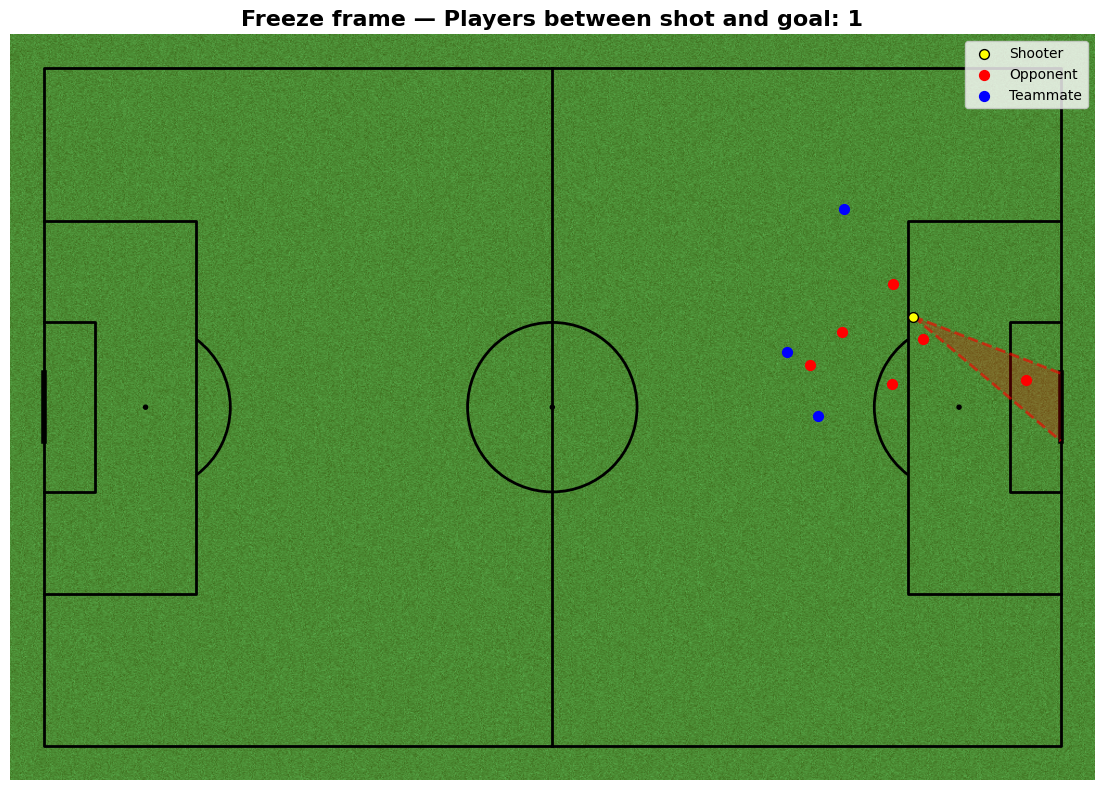

In [235]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

# Get a random shot from ds2
sample_row = ds2.sample(1).iloc[0]

# Shooter position
loc_x, loc_y = sample_row["loc_x"], sample_row["loc_y"]
ff = sample_row["shot_freeze_frame"]

# Calculate vectors to goalposts
line_bottom = np.array([GOAL_X - loc_x, GOAL_Y_BOTTOM - loc_y])
line_top = np.array([GOAL_X - loc_x, GOAL_Y_TOP - loc_y])

# Draw pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw(figsize=(12, 8))

# Draw shooting cone
cone = Polygon([[loc_x, loc_y],
                [GOAL_X, GOAL_Y_BOTTOM],
                [GOAL_X, GOAL_Y_TOP]],
                closed=True, facecolor='red', alpha=0.25)
ax.add_patch(cone)

# Shooter
pitch.scatter(loc_x, loc_y, ax=ax, c='yellow', s=50, label='Shooter', zorder=3, edgecolor='black')

# Flags to avoid duplicate legend labels
teammate_plotted = False
opponent_plotted = False

# Players in freeze frame
for p in ff:
    px, py = p["location"]
    if p["teammate"]:
        pitch.scatter(px, py, ax=ax, c='blue', s=50, 
                      label='Teammate' if not teammate_plotted else "")
        teammate_plotted = True
    else:
        pitch.scatter(px, py, ax=ax, c='red', s=50, 
                      label='Opponent' if not opponent_plotted else "")
        opponent_plotted = True

# Cone boundaries
ax.plot([loc_x, GOAL_X], [loc_y, GOAL_Y_BOTTOM], 'r--', linewidth=2, alpha=0.6)
ax.plot([loc_x, GOAL_X], [loc_y, GOAL_Y_TOP], 'r--', linewidth=2, alpha=0.6)

# Title with computed value
ax.set_title(f"Freeze frame — Players between shot and goal: {sample_row['num_players_between']}", fontsize=16, fontweight='bold')

plt.legend()
plt.show()

### Distance to closest defender

This feature captures the **immediate defensive pressure** applied to the shooter by measuring the Euclidean distance from the shooting location to the closest opponent.  

The distance is computed as:  

$
d = \min_{p \in O} \sqrt{(x_p - x_s)^2 + (y_p - y_s)^2}
$

where $(x_s, y_s)$ is the shooter’s position and $O$ is the set of all opponent players in the freeze frame.


In [236]:
import numpy as np

# Define the maximum distance
MAX_DIST = np.sqrt(120**2 + 80**2)  # ≈ 144.22 metri

def closest_defender_distance(row):
    """Compute the distance to the closest opponent.
    If no defenders are present, return MAX_DIST (campo libero).
    """
    sx, sy = row["loc_x"], row["loc_y"]
    ff = row["shot_freeze_frame"]

    min_dist = np.inf
    for p in ff:
        if not p["teammate"]:  # only opponents
            px, py = p["location"]
            dist = np.sqrt((px - sx) ** 2 + (py - sy) ** 2)
            if dist < min_dist:
                min_dist = dist

    return min_dist if min_dist != np.inf else MAX_DIST

# Apply to dataset
ds2["closest_defender_dist"] = ds2.apply(closest_defender_distance, axis=1)

# Check
print(ds2["closest_defender_dist"].describe())
print("Number of values equal to MAX_DIST:", (ds2["closest_defender_dist"] == MAX_DIST).sum())


count    86833.000000
mean         3.043820
std          2.490849
min          0.000000
25%          1.414214
50%          2.319483
75%          3.800000
max        144.222051
Name: closest_defender_dist, dtype: float64
Number of values equal to MAX_DIST: 2


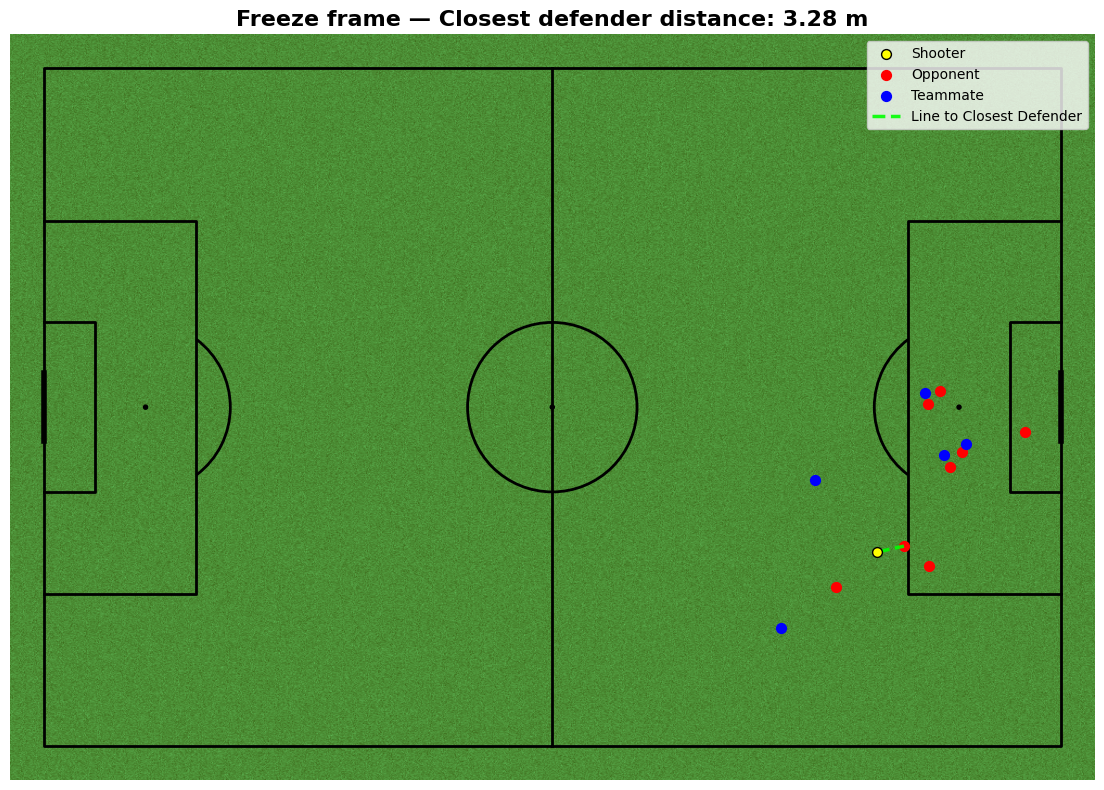

In [237]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np

# Get a random shot from ds2
sample_row = ds2.sample(1).iloc[0]

# Shooter position
loc_x, loc_y = sample_row["loc_x"], sample_row["loc_y"]
ff = sample_row["shot_freeze_frame"]

# Compute the minimum distance to the closest defender
min_dist = closest_defender_distance(sample_row)

# Get the location of the closest defender
closest_def = None
for p in ff:
    if not p["teammate"]:  # only opponents
        px, py = p["location"]
        dist = np.sqrt((px - loc_x) ** 2 + (py - loc_y) ** 2)
        if abs(dist - min_dist) < 1e-6:  # match with computed value
            closest_def = (px, py)
            break

# Draw pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw(figsize=(12, 8))

# Shooter
pitch.scatter(loc_x, loc_y, ax=ax, c='yellow', s=50, label='Shooter', zorder=3, edgecolor='black')

# Flags to avoid duplicate legend labels
teammate_plotted = False
opponent_plotted = False

# Players in freeze frame
for p in ff:
    px, py = p["location"]
    if p["teammate"]:
        pitch.scatter(px, py, ax=ax, c='blue', s=50, 
                      label='Teammate' if not teammate_plotted else "")
        teammate_plotted = True
    else:
        pitch.scatter(px, py, ax=ax, c='red', s=50, 
                      label='Opponent' if not opponent_plotted else "")
        opponent_plotted = True

# Line to the closest defender
if closest_def is not None:
    cx, cy = closest_def
    ax.plot([loc_x, cx], [loc_y, cy], color='lime', linewidth=2.5, alpha=0.9, 
            label="Line to Closest Defender", linestyle='--')

# Title with computed value
ax.set_title(f"Freeze frame — Closest defender distance: {min_dist:.2f} m", 
             fontsize=16, fontweight='bold')

plt.legend()
plt.show()

### Goalkeeper positioning

For each shot, let's identify the **opponent goalkeeper** in the freeze frame and measure how well he is aligned with the direct shot line towards the center of the goal.  

- If the goalkeeper is perfectly aligned, the value is **0**.  
- The larger the value, the more the goalkeeper is **out of position** relative to the shot.  


In [238]:
import numpy as np

def goalkeeper_positioning(row):
    # Shooter position
    loc_x, loc_y = row["loc_x"], row["loc_y"]
    ff = row["shot_freeze_frame"]
    
    # Goal center
    goal_x, goal_y = GOAL_X, (GOAL_Y_TOP + GOAL_Y_BOTTOM) / 2

    # Find goalkeeper among opponents
    gk = None
    for p in ff:
        if (not p["teammate"]) and p["position"]["name"] == "Goalkeeper":
            gk = p["location"]
            break
    if gk is None:
        return np.nan

    gk_x, gk_y = gk

    # Perpendicular distance from goalkeeper to shot line
    # Formula = |Ax + By + C| / sqrt(A^2 + B^2)

    A = goal_y - loc_y
    B = loc_x - goal_x
    C = goal_x * loc_y - goal_y * loc_x

    numerator = abs(A * gk_x + B * gk_y + C)
    denominator = np.sqrt(A ** 2 + B ** 2)
    d = numerator / denominator
    
    return d

# Apply to dataset
ds2["goalkeeper_positioning"] = ds2.apply(goalkeeper_positioning, axis=1)

# Show a preview
ds2[["goalkeeper_positioning"]].head()


goalkeeper_positioning
0                1.067157
1                0.992847
2                0.552005
3                0.359746
4                0.151126

In [239]:
# Count NaN Values Before
nan_counts = ds2["goalkeeper_positioning"].isna().sum()
print("NaN counts in DS2:", nan_counts)

# Manage NaN values with the median
ds2["goalkeeper_positioning"] = ds2["goalkeeper_positioning"].fillna(ds2["goalkeeper_positioning"].median())

# Count NaN Values After
nan_counts = ds2["goalkeeper_positioning"].isna().sum()
print("NaN counts in DS2 (managed):", nan_counts)

NaN counts in DS2: 100
NaN counts in DS2 (managed): 0


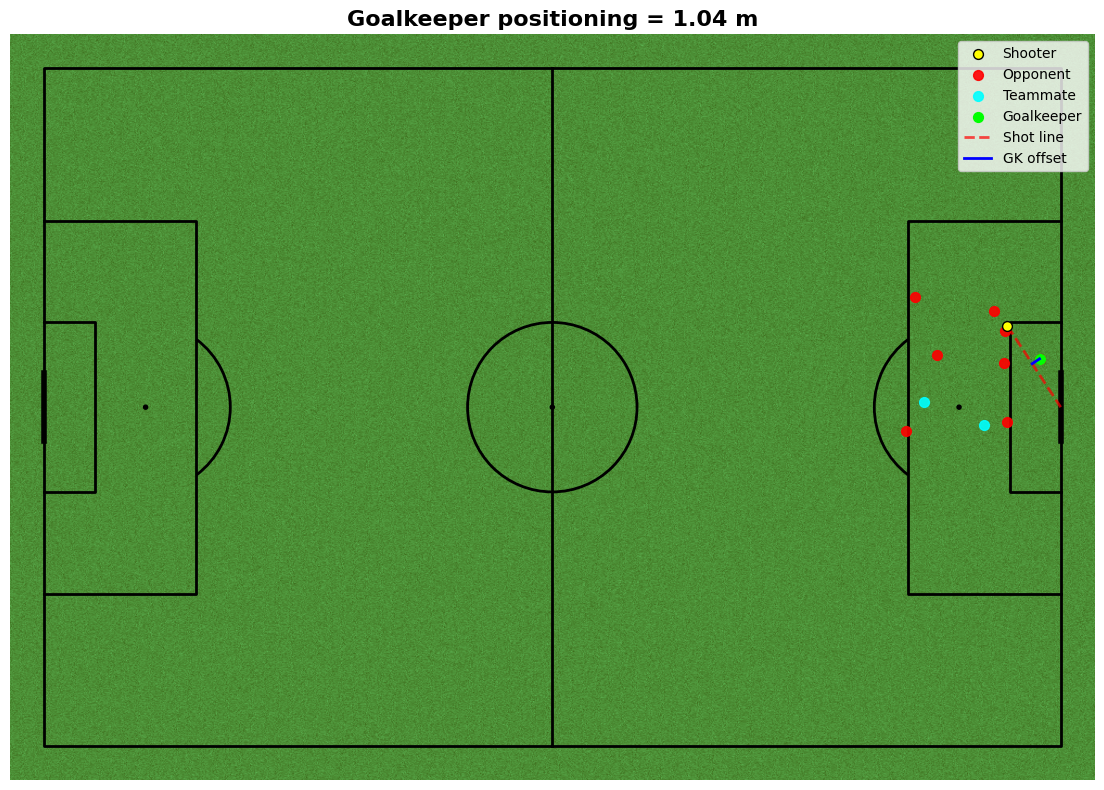

In [240]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np

# Pick a random shot
sample_row = ds2.sample(1).iloc[0]

# Shooter position
loc_x, loc_y = sample_row["loc_x"], sample_row["loc_y"]
ff = sample_row["shot_freeze_frame"]

# Goal center
goal_x, goal_y = GOAL_X, (GOAL_Y_TOP + GOAL_Y_BOTTOM) / 2

# Get goalkeeper position
gk = None
for p in ff:
    if (not p["teammate"]) and p["position"]["name"] == "Goalkeeper":
        gk = p["location"]
        break

# Compute value with the function
gk_dist = goalkeeper_positioning(sample_row)

# Draw pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw(figsize=(12, 8))

# Shooter
pitch.scatter(loc_x, loc_y, ax=ax, c='yellow', s=50, label="Shooter", zorder=3, edgecolor='black')

# Flags to avoid duplicate labels
teammate_plotted = False
opponent_plotted = False

# All players
for p in ff:
    px, py = p["location"]
    if p["teammate"]:
        pitch.scatter(px, py, ax=ax, c='cyan', s=50, alpha=0.9,
                      label="Teammate" if not teammate_plotted else "")
        teammate_plotted = True
    else:
        pitch.scatter(px, py, ax=ax, c='red', s=50, alpha=0.9,
                      label="Opponent" if not opponent_plotted else "")
        opponent_plotted = True

# Highlight goalkeeper
if gk is not None:
    kx, ky = gk
    pitch.scatter(kx, ky, ax=ax, c='lime', s=50, label="Goalkeeper")

    # Draw shot line
    ax.plot([loc_x, goal_x], [loc_y, goal_y], 'r--', linewidth=2, alpha=0.7, label="Shot line")

    # Compute projection point of GK on shot line
    A = np.array([loc_x, loc_y])
    B = np.array([goal_x, goal_y])
    P = np.array([kx, ky])
    AB = B - A
    AP = P - A
    t = np.dot(AP, AB) / np.dot(AB, AB)
    proj = A + t * AB  # projection point

    # Draw GK offset line
    ax.plot([kx, proj[0]], [ky, proj[1]], color='blue', linewidth=2, alpha=1, label="GK offset")

    # Title with computed distance
    ax.set_title(f"Goalkeeper positioning = {gk_dist:.2f} m",
                 fontsize=16, fontweight='bold')

# Fix legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper right")

plt.show()

### Free projection of the goal

This feature measures how much of the goal is visible to the shooter after accounting for the goalkeeper  

1. **Shooting cone**: angle between the two goalposts  

$
\text{total\_width} = \arctan2(y_{top}-y_{s}, x_{goal}-x_{s}) - \arctan2(y_{bottom}-y_{s}, x_{goal}-x_{s})
$

2. **Goalkeeper angular size**: body width projected from the shooter’s perspective  

$
\text{gk\_angle} = 2 \cdot \arctan\!\left(\frac{r_{gk}}{d}\right)
$

where $r_{gk} \approx 1.0\,m$ and $d$ is the shooter–GK distance.  

3. **Blocked cone**: if GK lies inside the cone  
$
\text{blocked} = \min(\text{total\_width}, \text{gk\_angle})
$

4. **Free ratio**: fraction of goal still visible  
$
\text{free\_ratio} = \frac{\max(0, \text{total\_width} - \text{blocked})}{\text{total\_width}}
$

The value ranges from **0** (fully blocked) to **1** (completely open goal).


In [241]:
import numpy as np

def compute_free_projection(row, gk_radius=1.0):
    # Shooter
    loc_x, loc_y = row["loc_x"], row["loc_y"]
    ff = row["shot_freeze_frame"]

    # Find goalkeeper
    gk = None
    for p in ff:
        if (not p["teammate"]) and p["position"]["name"] == "Goalkeeper":
            gk = p["location"]
            break
    if gk is None:
        return np.nan

    gk_x, gk_y = gk

    # Goal posts
    left_post = np.array([GOAL_X, GOAL_Y_BOTTOM])
    right_post = np.array([GOAL_X, GOAL_Y_TOP])
    shooter = np.array([loc_x, loc_y])
    gk = np.array([gk_x, gk_y])

    # Vectors to posts
    line_bottom = left_post - shooter
    line_top = right_post - shooter
    vec_gk = gk - shooter

    # Angles
    ang_bottom = np.arctan2(line_bottom[1], line_bottom[0])
    ang_top = np.arctan2(line_top[1], line_top[0])
    ang_gk = np.arctan2(vec_gk[1], vec_gk[0])

    # Normalize so ang_bottom < ang_top
    if ang_bottom > ang_top:
        ang_bottom, ang_top = ang_top, ang_bottom

    total_width = ang_top - ang_bottom

    # GK apparent angle based on distance
    d = np.linalg.norm(vec_gk)
    if d > 0:
        gk_angle = 2 * np.arctan(gk_radius / d)
    else:
        gk_angle = total_width          # GK over shooter 

    # Check if GK is inside the shooting cone
    blocked = 0
    if ang_bottom <= ang_gk <= ang_top:
        blocked = min(total_width, gk_angle)

    # Compute free ratio
    free_angle = max(0, total_width - blocked)
    free_ratio = free_angle / total_width if total_width > 0 else 0

    return free_ratio

# Apply to dataset
ds2["free_proj_goal"] = ds2.apply(compute_free_projection, axis=1)

# Preview
ds2[["free_proj_goal"]].head()


free_proj_goal
0        0.713237
1        0.366981
2        0.554745
3        0.531576
4        0.719845

In [242]:
# Count NaN Values Before
nan_counts = ds2["free_proj_goal"].isna().sum()
print("NaN counts in DS2:", nan_counts)

# Manage NaN values with the median
ds2["free_proj_goal"] = ds2["free_proj_goal"].fillna(ds2["free_proj_goal"].median())

# Count NaN Values After 
nan_counts = ds2["free_proj_goal"].isna().sum()
print("NaN counts in DS2 (managed):", nan_counts)

NaN counts in DS2: 100
NaN counts in DS2 (managed): 0


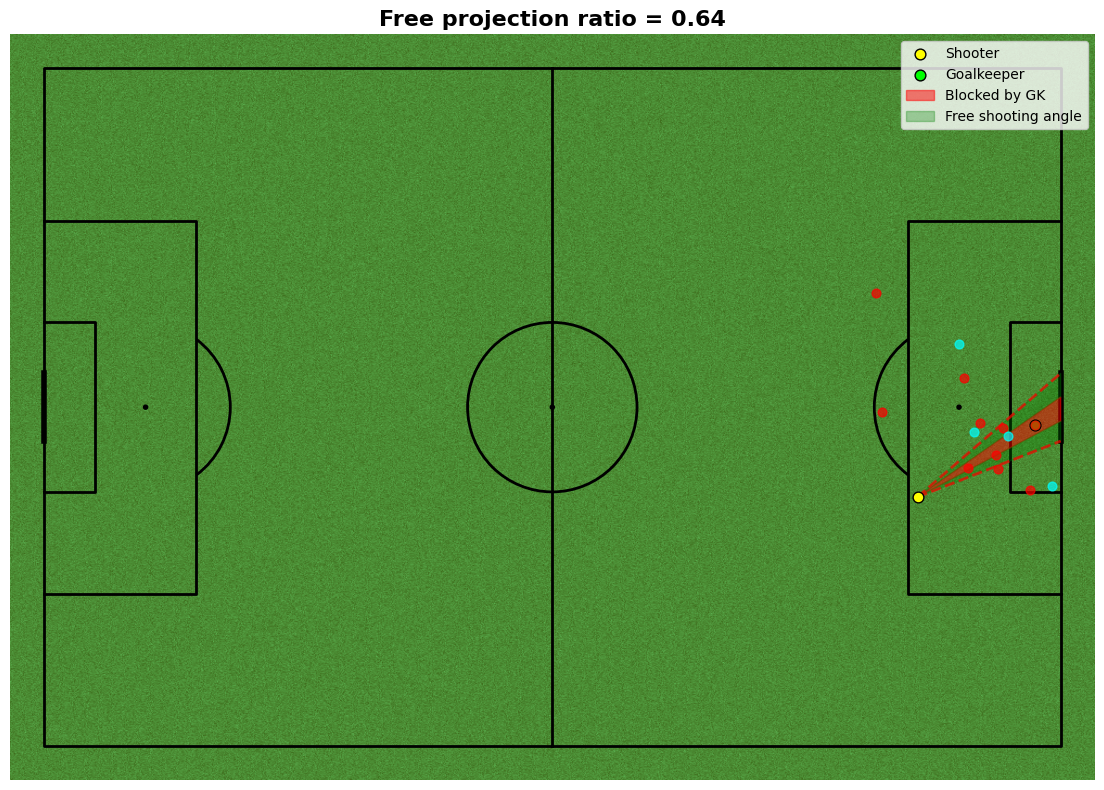

In [243]:
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Select a random shot and compute its free projection ratio
row = ds2.sample(1).iloc[0]
free_ratio = compute_free_projection(row)

# Shooter location and freeze frame
loc_x, loc_y = row["loc_x"], row["loc_y"]
ff = row["shot_freeze_frame"]

# Find the goalkeeper among opponents
gk = None
for p in ff:
    if (not p["teammate"]) and p["position"]["name"] == "Goalkeeper":
        gk = p["location"]
        break

if gk is None:
    print("No goalkeeper found for this shot")
else:
    gk_x, gk_y = gk

    # Define goal posts
    left_post = np.array([GOAL_X, GOAL_Y_BOTTOM])
    right_post = np.array([GOAL_X, GOAL_Y_TOP])
    shooter = np.array([loc_x, loc_y])
    gk = np.array([gk_x, gk_y])

    # Compute angles
    ang_bottom = np.arctan2(left_post[1] - loc_y, left_post[0] - loc_x)
    ang_top = np.arctan2(right_post[1] - loc_y, right_post[0] - loc_x)
    ang_gk = np.arctan2(gk_y - loc_y, gk_x - loc_x)

    # Ensure angle order (bottom < top)
    if ang_bottom > ang_top:
        ang_bottom, ang_top = ang_top, ang_bottom

    # Shooter–goalkeeper distance
    d = np.sqrt((gk_x - loc_x)**2 + (gk_y - loc_y)**2)

    # Apparent goalkeeper size (approx. half body width = 1 m)
    gk_radius = 1.0  
    gk_angle = 2 * np.arctan(gk_radius / d)

    # Blocked angular interval by goalkeeper
    start_block = ang_gk - gk_angle / 2
    end_block = ang_gk + gk_angle / 2

    # Clip to useful cone
    start_block = max(start_block, ang_bottom)
    end_block = min(end_block, ang_top)

    # Projection of angles onto goal line (x = GOAL_X)
    dy_bottom = np.tan(ang_bottom) * (GOAL_X - loc_x)
    dy_top = np.tan(ang_top) * (GOAL_X - loc_x)
    dy_gk_left = np.tan(start_block) * (GOAL_X - loc_x)
    dy_gk_right = np.tan(end_block) * (GOAL_X - loc_x)

    proj_left = np.array([GOAL_X, loc_y + dy_bottom])
    proj_right = np.array([GOAL_X, loc_y + dy_top])
    proj_gk_left = np.array([GOAL_X, loc_y + dy_gk_left])
    proj_gk_right = np.array([GOAL_X, loc_y + dy_gk_right])

    # Draw the pitch
    pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
    fig, ax = pitch.draw(figsize=(12, 8))

    # Plot shooter and goalkeeper
    pitch.scatter(loc_x, loc_y, ax=ax, c='yellow', s=60, label="Shooter", edgecolor='black', zorder=4)
    pitch.scatter(gk_x, gk_y, ax=ax, c='lime', s=60, label="Goalkeeper", edgecolor='black', zorder=4)

    # Plot all other players
    for p in ff:
        px, py = p["location"]
        color = 'cyan' if p["teammate"] else 'red'
        pitch.scatter(px, py, ax=ax, c=color, s=40, alpha=0.7, zorder=4)

    # Full shooting cone
    ax.plot([loc_x, proj_left[0]], [loc_y, proj_left[1]], 'r--', lw=2, alpha=0.7)
    ax.plot([loc_x, proj_right[0]], [loc_y, proj_right[1]], 'r--', lw=2, alpha=0.7)

    # Blocked area by goalkeeper (red)
    ax.fill([loc_x, proj_gk_left[0], proj_gk_right[0]],
            [loc_y, proj_gk_left[1], proj_gk_right[1]],
            color="red", alpha=0.5, label="Blocked by GK")

    # Free shooting areas (green)
    ax.fill([loc_x, proj_left[0], proj_gk_left[0]],
            [loc_y, proj_left[1], proj_gk_left[1]],
            color="green", alpha=0.3)
    ax.fill([loc_x, proj_gk_right[0], proj_right[0]],
            [loc_y, proj_gk_right[1], proj_right[1]],
            color="green", alpha=0.3, label="Free shooting angle")

    # Title and legend
    ax.set_title(f"Free projection ratio = {free_ratio:.2f}", fontsize=16, fontweight='bold')
    ax.legend(loc="upper right")

    plt.show()

### Drop the `shot_freeze_frame` column

The `shot_freeze_frame` field contains the full list of player positions at the shot moment.  
Since the meaningful features  (e.g. closest defender distance, free projection), have already been extracted, keeping the entire raw structure would only increase memory usage and slow computations.


In [244]:
ds2.drop(columns=["shot_freeze_frame"], inplace=True)

### Final Check and Save

The final dataset is then saved as `DS2.csv`

In [245]:
# Final dataset check before saving
report = []

for col in ds2.columns:
    dtype = ds2[col].dtype
    n_missing = ds2[col].isna().sum()

    if pd.api.types.is_numeric_dtype(ds2[col]):
        col_min = ds2[col].min()
        col_max = ds2[col].max()
        unique_vals = "-"
    else:
        col_min, col_max = "-", "-"
        unique_vals = ds2[col].unique()

    report.append([col, dtype, n_missing, col_min, col_max, unique_vals])

report_df = pd.DataFrame(report, columns=["Column", "Dtype", "Missing", "Min", "Max", "Unique Values"])
display(report_df)

Column    Dtype  Missing      Min         Max  \
0                 event_id   object        0        -           -   
1                 match_id    int64        0     7298     4020846   
2                player_id  float64        0   2935.0    482216.0   
3                   minute    int64        0        0         138   
4                   second    int64        0        0          59   
5                   period   object        0        -           -   
6                shot_type   object        0        -           -   
7           shot_technique   object        0        -           -   
8           shot_body_part   object        0        -           -   
9             play_pattern   object        0        -           -   
10          under_pressure     bool        0    False        True   
11         shot_first_time     bool        0    False        True   
12         shot_one_on_one     bool        0    False        True   
13               target_xg  float64        0  0.00018    0.995122   
14                   loc_x  float64        0     30.2       120.5   
15                   loc_y  float64        0      0.3        80.0   
16              end_shot_x  float64        0     66.5       120.0   
17              end_shot_y  float64        0      0.1        80.0   
18              end_shot_z  float64        0     -1.0         7.8   
19    end_shot_z_available    int64        0        0           1   
20     shot_from_set_piece    int64        0        0           1   
21        distance_to_goal  float64        0      0.4   92.800862   
22           angle_to_goal  float64        0      0.0    2.942744   
23                  gender   object        0        -           -   
24                    role   object        0        -           -   
25     num_players_between    int64        0        0          13   
26   closest_defender_dist  float64        0      0.0  144.222051   
27  goalkeeper_positioning  float64        0      0.0   80.610173   
28          free_proj_goal  float64        0      0.0         1.0   

                                        Unique Values  
0   [c577e730-b9f5-44f2-9257-9e7730c23d7b, bbc2c68...  
1                                                   -  
2                                                   -  
3                                                   -  
4                                                   -  
5                 [Regular Time, Penalty, Extra Time]  
6   [Open Play, Free Kick, Penalty, Corner, Kick Off]  
7                           [Normal, Aerial, Special]  
8                [Right Foot, Left Foot, Head, Other]  
9           [Set Piece, Regular Play, Counter Attack]  
10                                                  -  
11                                                  -  
12                                                  -  
13                                                  -  
14                                                  -  
15                                                  -  
16                                                  -  
17                                                  -  
18                                                  -  
19                                                  -  
20                                                  -  
21                                                  -  
22                                                  -  
23                                     [male, female]  
24                                [MID, DEF, FWD, GK]  
25                                                  -  
26                                                  -  
27                                                  -  
28                                                  -

In [246]:
# Save DS2 to disk
ds2.to_csv("../task1_xg/data/DS2.csv", index=False)

## DS3 – Preparing data for classical machine learning models

To create **DS3**, **DS2** is transformed into a fully numerical dataset tailored for classical tabular models such as **Logistic Regression**.  

The preprocessing steps are:  

- **Dropping ID columns**: identifiers such as player or match IDs carry no predictive value and are removed.  

- **One-Hot Encoding (OHE)**: categorical features (e.g., play pattern, shot technique, period, role) are expanded into binary columns. This prevents imposing an arbitrary order and allows models to handle categories independently. 

- **Feature scaling (MinMaxScaler)**: all numerical variables are normalized to the range **[0, 1]**. This ensures that distance-based and regularized models (e.g., Logistic Regression) do not become biased toward features with larger magnitudes.  

This preprocessing is **essential for Logistic Regression**, which relies on feature scaling and cannot handle categorical variables directly.  
For other models such as **Random Forest, XGBoost, or Neural Networks**, an alternative dataset (**DS4**) where categorical features are encoded differently (e.g., Label Encoding + embeddings) to better exploit their architecture is created


In [248]:
import pandas as pd

# Load DS2
ds2 = pd.read_csv("../task1_xg/data/DS2.csv")

# Print column name and dtype
for col in ds2.columns:
    print(f"{col}: {ds2[col].dtype}")

event_id: object
match_id: int64
player_id: float64
minute: int64
second: int64
period: object
shot_type: object
shot_technique: object
shot_body_part: object
play_pattern: object
under_pressure: bool
shot_first_time: bool
shot_one_on_one: bool
target_xg: float64
loc_x: float64
loc_y: float64
end_shot_x: float64
end_shot_y: float64
end_shot_z: float64
end_shot_z_available: int64
shot_from_set_piece: int64
distance_to_goal: float64
angle_to_goal: float64
gender: object
role: object
num_players_between: int64
closest_defender_dist: float64
goalkeeper_positioning: float64
free_proj_goal: float64


In [249]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Copy DS2 dataframe to work with
ds3 = ds2.copy()

# Drop ID columns
ds3 = ds3.drop(columns=['event_id', 'match_id', 'player_id'])

# Categorical features
categorical_cols = ['period', 'shot_type', 'shot_technique',
                    'shot_body_part', 'play_pattern', 
                    'gender', 'role']

ds3 = pd.get_dummies(ds3, columns=categorical_cols, drop_first=True)

# Numerical features to normalize
num_cols = ['minute', 'second', 
            'loc_x', 'loc_y', 'end_shot_x', 'end_shot_y', 'end_shot_z',
            'distance_to_goal', 'angle_to_goal', 'num_players_between',
            'closest_defender_dist', 'goalkeeper_positioning', 'free_proj_goal']

scaler = MinMaxScaler()
ds3[num_cols] = scaler.fit_transform(ds3[num_cols])


# Convert to bool
ds3["end_shot_z_available"] = ds3["end_shot_z_available"].astype(bool)
ds3["shot_from_set_piece"] = ds3["shot_from_set_piece"].astype(bool)


### Final Check and Save

The final dataset is then saved as `DS3.csv`

In [250]:
# Final dataset check before saving
report = []

for col in ds3.columns:
    dtype = ds3[col].dtype
    n_missing = ds3[col].isna().sum()

    if pd.api.types.is_numeric_dtype(ds3[col]):
        col_min = ds3[col].min()
        col_max = ds3[col].max()
        unique_vals = "-"
    else:
        col_min, col_max = "-", "-"
        unique_vals = ds3[col].unique()

    report.append([col, dtype, n_missing, col_min, col_max, unique_vals])

report_df = pd.DataFrame(report, columns=["Column", "Dtype", "Missing", "Min", "Max", "Unique Values"])
display(report_df)

Column    Dtype  Missing      Min       Max  \
0                      minute  float64        0      0.0       1.0   
1                      second  float64        0      0.0       1.0   
2              under_pressure     bool        0    False      True   
3             shot_first_time     bool        0    False      True   
4             shot_one_on_one     bool        0    False      True   
5                   target_xg  float64        0  0.00018  0.995122   
6                       loc_x  float64        0      0.0       1.0   
7                       loc_y  float64        0      0.0       1.0   
8                  end_shot_x  float64        0      0.0       1.0   
9                  end_shot_y  float64        0      0.0       1.0   
10                 end_shot_z  float64        0      0.0       1.0   
11       end_shot_z_available     bool        0    False      True   
12        shot_from_set_piece     bool        0    False      True   
13           distance_to_goal  float64        0      0.0       1.0   
14              angle_to_goal  float64        0      0.0       1.0   
15        num_players_between  float64        0      0.0       1.0   
16      closest_defender_dist  float64        0      0.0       1.0   
17     goalkeeper_positioning  float64        0      0.0       1.0   
18             free_proj_goal  float64        0      0.0       1.0   
19             period_Penalty     bool        0    False      True   
20        period_Regular Time     bool        0    False      True   
21        shot_type_Free Kick     bool        0    False      True   
22         shot_type_Kick Off     bool        0    False      True   
23        shot_type_Open Play     bool        0    False      True   
24          shot_type_Penalty     bool        0    False      True   
25      shot_technique_Normal     bool        0    False      True   
26     shot_technique_Special     bool        0    False      True   
27   shot_body_part_Left Foot     bool        0    False      True   
28       shot_body_part_Other     bool        0    False      True   
29  shot_body_part_Right Foot     bool        0    False      True   
30  play_pattern_Regular Play     bool        0    False      True   
31     play_pattern_Set Piece     bool        0    False      True   
32                gender_male     bool        0    False      True   
33                   role_FWD     bool        0    False      True   
34                    role_GK     bool        0    False      True   
35                   role_MID     bool        0    False      True   

   Unique Values  
0              -  
1              -  
2              -  
3              -  
4              -  
5              -  
6              -  
7              -  
8              -  
9              -  
10             -  
11             -  
12             -  
13             -  
14             -  
15             -  
16             -  
17             -  
18             -  
19             -  
20             -  
21             -  
22             -  
23             -  
24             -  
25             -  
26             -  
27             -  
28             -  
29             -  
30             -  
31             -  
32             -  
33             -  
34             -  
35             -

In [251]:
ds3.to_csv("../task1_xg/data/DS3.csv", index=False)

# IDEE PER FUTURE IMPLEMENTAZIONI:

- LSTM CON ANALISI DI INTERE PARTITE
- AGGIUNTA DI EVENTI PRECEDENTI PER STUDIARE COME E' ARRIVATA LA PALLA AL TIRATORE
- UTILIZZARE GRAPH ANALYSIS O IMAGE DETECTION PER STUDIARE I FREEZE FRAMES E DARLI A UN TRANSFORMER AD ESEMPIO